### ELE075 - Sistemas Nebulosos
**Aluna:** Thais Menegaldi <br>

# Atividade Prática 3 - Parte 1

In [1]:
# !pip install torch==1.0.1 torchvision==0.2.2
# !git clone https://github.com/jfpower/anfis-pytorch

In [2]:
import os
import sys
import torch
import scipy.io 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
sys.path.insert(0, '../anfis-pytorch')
import anfis
from membership import *
import experimental

plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams.update({'font.size': 12})

## Problema 2 - Aproximação de uma Função

$y = sen(x)$ no intervalo $x \in [0, 2\pi]$

In [3]:
x_ = np.linspace(start=0, stop=2*np.pi, num=100)
y_ = np.sin(x_)

Para utilizar o modelo **ANFIS** implementado do repositório importado é necessário adaptar os dados para que fiquem no formato aceito, baseado em Tensores da biblioteca PyTorch. Essas conversão são feitas a seguir

In [4]:
x = torch.Tensor(x_).unsqueeze(1)
y = torch.Tensor(y_).unsqueeze(1)
print('Formato dos dados de entrada: ', x.shape, '\nFormato dos dados de saída: ', y.shape)

Formato dos dados de entrada:  torch.Size([100, 1]) 
Formato dos dados de saída:  torch.Size([100, 1])


In [5]:
tensor_data = TensorDataset(x, y)
train_data = DataLoader(tensor_data, batch_size=10, shuffle=False)
data_tensor = train_data.dataset.tensors

A rede **ANFIS** utilizada é, por default, um sistema do tipo *Takagi-Sugeno* e usa funções de pertinência Gaussianas. Para esse problema foram definidas 3 regras. Abaixo, foram passados os parâmetros desejados para que o modelo da rede seja construído por meio do método `make_anfis`.

In [6]:
model = make_anfis(x=data_tensor[0], num_mfs=3, num_out=1, hybrid=False)

Uma vez que o modelo já foi construído, é feito, então o seu treinamento. O método `train_anfis` utiliza o algoritmo *Stochastic gradient descent (SGD)* como otimizador, a função de perda é o Erro Quadrático Médio (MSE) e a taxa de aprendizado é igual a $1x10^{-4}$.

In [7]:
model.train(mode = True)
experimental.train_anfis(model, train_data, 50)

### Training for 50 epochs, training size = 100 cases
epoch    0: MSE=0.43363, RMSE=0.65851 =inf%
epoch   10: MSE=0.09891, RMSE=0.31450 =inf%
epoch   20: MSE=0.06436, RMSE=0.25370 =inf%
epoch   30: MSE=0.02137, RMSE=0.14618 =inf%
epoch   40: MSE=0.00639, RMSE=0.07994 =inf%


O modelo resultante do treinamento foi:

In [8]:
print('\nResulting Model: \n\n', model)


Resulting Model: 

 AnfisNet(
  Rule  0: IF x0 is mf0
           THEN [[2.0521223545074463, -0.14090241491794586]]
  Rule  1: IF x0 is mf1
           THEN [[-1.0496177673339844, 0.28413814306259155]]
  Rule  2: IF x0 is mf2
           THEN [[0.4566303789615631, -0.133012592792511]]
  (layer): ModuleDict(
    (fuzzify): Input variables
    Variable x0
    - mf0: GaussMembFunc(mu=0.49695509672164917, sigma=2.0055716037750244)
    - mf1: GaussMembFunc(mu=3.4813177585601807, sigma=2.305337429046631)
    - mf2: GaussMembFunc(mu=6.532299995422363, sigma=2.0026116371154785)
    (rules): AntecedentLayer()
    (consequent): PlainConsequentLayer()
  )
)


As funções de pertinência construídas tem o seguinte formato:

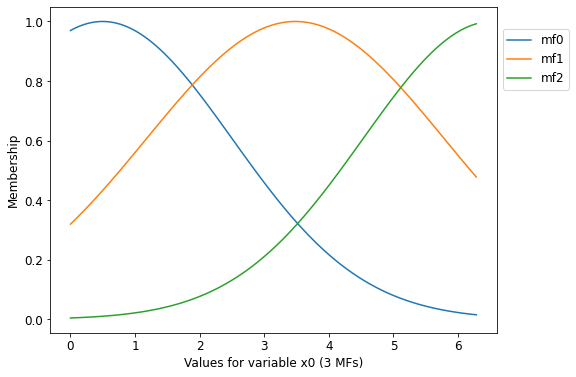

In [9]:
experimental.plot_all_mfs(model, train_data.dataset.tensors[0])

A comparação entre a saída prevista e a saída esperada, junto ao Erro Quadrático Mínimo resultante são mostrados a seguir:

	Saída esperada x Saída prevista


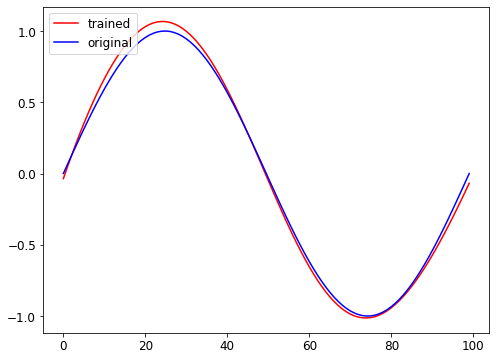


MSE =  0.0019439284224063158


In [10]:
print('\tSaída esperada x Saída prevista')
y_hat = model(train_data.dataset.tensors[0])
experimental.plotResults(y, y_hat)
MSE, _, _ = experimental.calc_error(y, y_hat)
print('\nMSE = ', float(MSE))

In [11]:
del model

## Problema 3 - Previsão de uma Série Temporal

Leitura dos dados da Série Temporal

In [12]:
file_path = os.path.abspath('./mg.mat')
x_ = scipy.io.loadmat(file_path)['x']

Os dados foram dividos entre conjunto de treinamento e de teste de modo que:
- 80% dos dados foram para o conjunto de treinamento
- 20% dos dados foram para o conjunto de teste

In [13]:
x_train = x_[:round(.8*x_.shape[0])]
x_test = x_[round(.8*x_.shape[0]):]

Para a solução deste problema os dados de entrada foram dividios em quatro entradas correspondentes a:

- $x(t)$
- $x(t - 6)$
- $x(t - 12)$
- $x(t - 18)$

E a saída do modelo será uma previsão feita 6 passos à frente:

- $y_{out} = x(t + 6)$

A reorganização dos dados de entrada foi feita tal que a entrada resultante ficou com o seguinte formato:
$X = [x(t - 18), \ x(t - 12), \ x(t - 6), \ x(t)]$

In [14]:
num_features = 4
division = 6 * num_features

In [15]:
# input and outup data for training
x_input = np.concatenate((x_train[18:-division+18], x_train[12:-division+12], x_train[6:-division+6], x_train[:-division]), axis=1)
x_out = x_train[division:]

# input and output data for test
x_in_test = np.concatenate((x_test[18:-division+18], x_test[12:-division+12], x_test[6:-division+6], x_test[:-division]), axis=1)
x_out_test = x_test[division:]

Assim como no Problema 2, faz-se necessária a conversão dos dados para o formato de tensores, possibilitando, assim, seu uso dentro do modelo **ANFIS**

In [16]:
x = torch.Tensor(x_input)
x_test_torch = torch.Tensor(x_in_test)
print('Formato dos dados de entrada utilizados para o treinamento: ', x.shape)
print('Formato dos dados de entrada utilizados para teste: ', x_test_torch.shape)

Formato dos dados de entrada utilizados para o treinamento:  torch.Size([777, 4])
Formato dos dados de entrada utilizados para teste:  torch.Size([176, 4])


In [17]:
y = torch.Tensor(x_out)
y_test_torch = torch.Tensor(x_out_test)
print('Formato dos dados de saída utilizados para o treinamento: ', y.shape)
print('Formato dos dados de saída utilizados para teste: ', y_test_torch.shape)

Formato dos dados de saída utilizados para o treinamento:  torch.Size([777, 1])
Formato dos dados de saída utilizados para teste:  torch.Size([176, 1])


Dados formatados para o treinamento da rede:

In [18]:
tensor_data = TensorDataset(x, y)
train_data = DataLoader(tensor_data, batch_size = 10, shuffle=False)
x_tensor = train_data.dataset.tensors

Dados formatados para serem utilizados como teste:

In [19]:
tensor_data_test = TensorDataset(x_test_torch, y_test_torch)
test_data = DataLoader(tensor_data_test, batch_size = 10, shuffle=False)
x_test_tensor = test_data.dataset.tensors

Para este problema, foram utilizadas quatro funções de pertinência do tipo Sino Generalizado em uma rede **ANFIS** do tipo *Takagi-Sugeno*. Essas funções foram definidas abaixo e, em seguida, passdas para a função `AnfisNet`que constrói o modelo 

In [20]:
membership_functions = [
        ('xm18', make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
        ('xm12', make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
        ('xm6',  make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
        ('x',    make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
        ]
output_var = ['xp6']
model = anfis.AnfisNet('Problema 3', membership_functions, output_var)

Uma vez que o modelo já foi construído, é feito, então o seu treinamento utilizando o método `train_anfis` cujas características são as mesmas do problema 2

In [21]:
model.train(mode = True)
experimental.train_anfis(model, train_data, 10, show_plots=False)

### Training for 10 epochs, training size = 777 cases
epoch    0: MSE=0.00001, RMSE=0.00276 =0.22%
epoch    1: MSE=0.00001, RMSE=0.00276 =0.22%
epoch    2: MSE=0.00001, RMSE=0.00276 =0.22%
epoch    3: MSE=0.00001, RMSE=0.00276 =0.22%
epoch    4: MSE=0.00001, RMSE=0.00276 =0.22%
epoch    5: MSE=0.00001, RMSE=0.00276 =0.22%
epoch    6: MSE=0.00001, RMSE=0.00276 =0.22%
epoch    7: MSE=0.00001, RMSE=0.00275 =0.22%
epoch    8: MSE=0.00001, RMSE=0.00275 =0.22%
epoch    9: MSE=0.00001, RMSE=0.00275 =0.22%


O modelo obtido após a etapa de treinamento foi:

In [22]:
print('\nResulting Model: \n\n', model)


Resulting Model: 

 AnfisNet(
  Rule  0: IF xm18 is mf0 and xm12 is mf0 and xm6 is mf0 and x is mf0
           THEN [[1.4733891487121582, 2.159273386001587, 0.44872334599494934, -2.245802402496338, 0.5994642376899719]]
  Rule  1: IF xm18 is mf0 and xm12 is mf0 and xm6 is mf0 and x is mf1
           THEN [[0.8523055911064148, 0.32464274764060974, -0.4615754783153534, -0.5506352782249451, 1.5126945972442627]]
  Rule  2: IF xm18 is mf0 and xm12 is mf0 and xm6 is mf1 and x is mf0
           THEN [[-2.2906527519226074, -14.444191932678223, 12.030709266662598, -5.557065963745117, 5.337870121002197]]
  Rule  3: IF xm18 is mf0 and xm12 is mf0 and xm6 is mf1 and x is mf1
           THEN [[-0.23502208292484283, 0.9988906979560852, -0.7367571592330933, -0.3704584836959839, 1.2149454355239868]]
  Rule  4: IF xm18 is mf0 and xm12 is mf1 and xm6 is mf0 and x is mf0
           THEN [[-11.17402172088623, 15.90457820892334, 0.5755629539489746, 17.10890769958496, -10.640653610229492]]
  Rule  5: IF xm1

A seguir, sao apresentados os plots das funções de pertinência que foram construídas

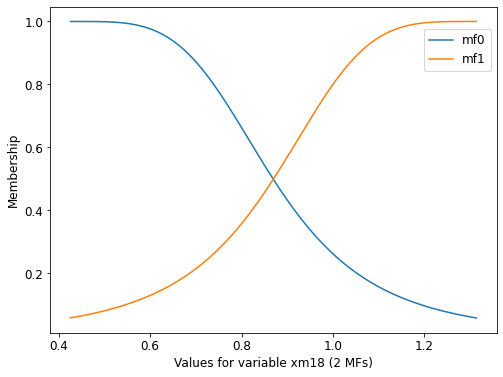

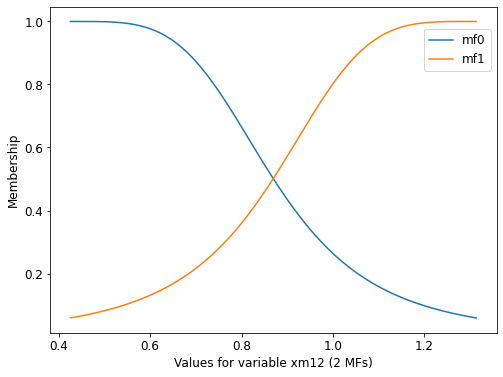

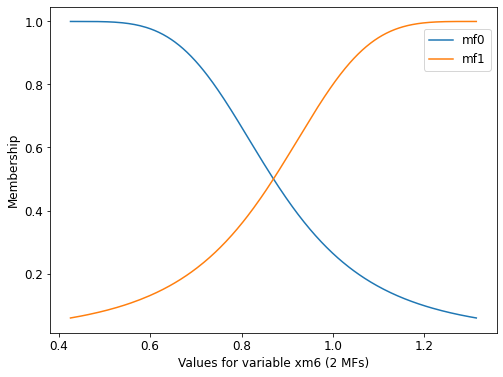

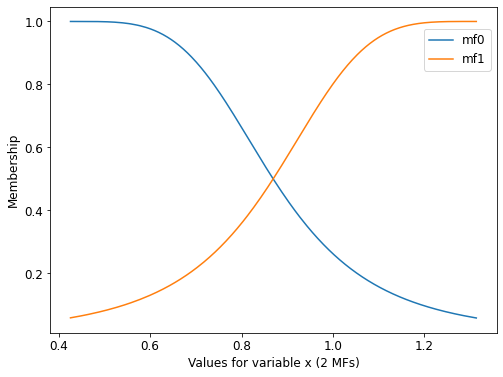

In [23]:
experimental.plot_all_mfs(model, train_data.dataset.tensors[0])

O gráfico a seguir mostra a saída prevista e a saída esperada junto ao Erro Quadrático Mínimo dos resultados do treinamento da rede

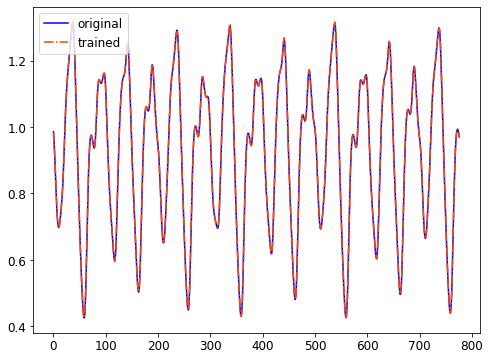


MSE =  7.588793323520804e-06


In [24]:
y_hat = model(train_data.dataset.tensors[0])
plt.plot(range(len(y)), y.numpy(), 'blue')
plt.plot(range(len(y_hat)), y_hat.detach().numpy(), 'orangered', linestyle='dashdot')
plt.legend(['original', 'trained'], loc='upper left')
plt.show()
MSE, _, _ = experimental.calc_error(y, y_hat)
print('\nMSE = ', float(MSE))

O teste da rede é feito utilizando a função `test_anfis` que realiza um único passo de *forward* com a entrada, implementada no respositório utilizado

In [25]:
experimental.test_anfis(model, test_data, show_plots=False)

### Testing for 176 cases
MS error=0.00001, RMS error=0.00294, percentage=0.25%


O gráfico resultante da saída prevista junto à saída real na etapa de teste é mostrado a seguir. Em seguida, é mostrado o valor do Erro Quadrático Mínimo obtido

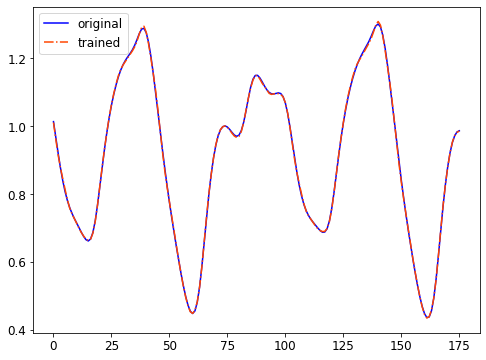


MSE =  8.618674655735958e-06


In [26]:
y_hat_test = model(test_data.dataset.tensors[0])
plt.plot(range(len(y_test_torch)), y_test_torch.numpy(), 'blue')
plt.plot(range(len(y_hat_test)), y_hat_test.detach().numpy(), 'orangered', linestyle='dashdot')
plt.legend(['original', 'trained'], loc='upper left')
plt.show()
MSE, _, _ = experimental.calc_error(y_test_torch, y_hat_test)
print('\nMSE = ', float(MSE))

In [27]:
del model